## Import Libs

In [1]:
import os
import warnings # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')
import random
import gc
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm # 进度条
import time

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler # 学习率调度器

import timm # 预训练神经网络库，可直接调用预训练好的模型
from PIL import Image
import albumentations as A # 数据增强库
from albumentations.pytorch import ToTensorV2

from collections import defaultdict # 记录 loss lr 等相关参数的变化
# 改变 终端颜色 方便观察
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

## CONFIG

In [2]:
is_debug = False

class CONFIG:
    seed = 308
    
    epochs = 10 if not is_debug else 2
    now_cv = 0
    
    img_size = [28, 28]
    train_batch_size = 256
    valid_batch_size = 512
    
    n_classes = 10

    n_workers = 1
    
    learning_rate = 1e-3
    weight_decay = 1e-6 # 一个参数而已
    scheduler = 'CosineAnnealingLR'
    # T_max : 经过多少 step 降到最低，训练一批 batch 为一个 step，一般训练到最后降到最低 所以可以根据训练数据量动态调整
    T_max = 33600 // train_batch_size * epochs 
    # 33600为train.csv中80%的数据量个数即训练数据量，一轮 (33600 // train_batch_size)个 batch，一共(33600 // train_batch_size) * epochs 个 batch
    min_lr = 1e-6
    
    model_name = "tf_efficientnetv2_s.in21k_ft_in1k"
    pool_name = "GeMPool" # 最后的全局池化层选择使用 GeMPool
    timm_pretrained = True # 是否使用预训练模型设置为 True，表示使用预训练模型
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    train_csv = "/kaggle/input/digit-recognizer/train.csv"
    img_path = "/kaggle/input/308-digit-recognizer-img/output"
    ckpt_save_path = "/kaggle/working/output"

## Set Random Seed

In [3]:
def set_seed(seed=308):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed(CONFIG.seed) # 固定随机种子，方便结果复现

## Data Progress

In [4]:
train = pd.read_csv(CONFIG.train_csv) # 读取训练的 .csv
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# 切分训练集测试集 前 80 % 数据作训练集，后 20 % 数据作验证集
num_train = len(train)
print(num_train // 5 * 4)

df_train = train.iloc[: num_train // 5 * 4, :].reset_index(drop=True) # .reset_index(drop=True) 重置索引
df_valid = train.iloc[num_train // 5 * 4:, :].reset_index(drop=True)
df_valid

33600


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8396,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8397,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8398,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Dataset and DataLoader

In [6]:
def transform_train(img):
    composition = A.Compose([
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),
        # albumentations 数据增强库的其他功能参考：https://blog.csdn.net/qq_27039891/article/details/100795846?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522613472AB-3AB7-4407-9825-DA5DD079F755%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=613472AB-3AB7-4407-9825-DA5DD079F755&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-5-100795846-null-null.142^v100^pc_search_result_base1&utm_term=albumentations%20%E6%95%B0%E6%8D%AE%E5%A2%9E%E5%BC%BA&spm=1018.2226.3001.4187
        
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

def transform_valid(img):
    composition = A.Compose([
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

In [7]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None, mode="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx, :] # 从 df 中取出 idx 这一行
        label = row.label
        if self.mode == "train":
            img_idx = idx
        elif self.mode == "valid":
            img_idx = idx + 33600 # 验证的数据从33600开始
        else:
            raise ValueError("mode not train or valid")
            
        img = Image.open(os.path.join(CONFIG.img_path, f"{img_idx}.jpg"))
        
        img = np.array(img).reshape(CONFIG.img_size[0], CONFIG.img_size[1], -1) # 形状为 (H, W, C)
        img = np.concatenate([img] * 3, axis=-1) # 为了使用预训练模型，将图像复制 3份 按channel拼接 输入通道变为 3
        
        if self.transform != None: # 可进行 totensor 数据增强 等操作
            img = self.transform(img) # ToTensor操作可自动将最后一维的 channel 提前，即 (H, W, C) --> (C, H, W)
        
        return img, label # Dataset 一般一次返回一条 X(特征), y(标签) 这样的形式

In [8]:
def prepare_loaders():
    train_datasets = MyDataset(df=df_train, transform=transform_train, mode="train")
    valid_datasets = MyDataset(df=df_valid, transform=transform_valid, mode="valid")
    
    train_loader = DataLoader(train_datasets, batch_size=CONFIG.train_batch_size, num_workers=CONFIG.n_workers, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_datasets, batch_size=CONFIG.valid_batch_size, num_workers=CONFIG.n_workers, shuffle=False, pin_memory=True)
    # valid_loader 一般不行打乱操作 所以 shuffle 为 False
    
    return train_loader, valid_loader

In [9]:
# 以下代码可检查Dataset，DataLoader是否实现基本功能
train_loader, valid_loader = prepare_loaders()
x_train, y_train = next(iter(train_loader))
x_valid, y_valid = next(iter(valid_loader))
print(f"X_train shape : {x_train.shape}") # (batch_size, channels, H, W)
print(f"y_train shape : {y_train.shape}")
print(f"x_valid shape : {x_valid.shape}")
print(f"y_valid shape : {y_valid.shape}")

# 删除变量，回收垃圾
del train_loader, valid_loader, x_train, y_train, x_valid, y_valid
gc.collect()

X_train shape : torch.Size([256, 3, 28, 28])
y_train shape : torch.Size([256])
x_valid shape : torch.Size([512, 3, 28, 28])
y_valid shape : torch.Size([512])


46

## Evaluation

In [10]:
def cal_ACC(y_true, y_preds):
    if len(y_true) != len(y_preds):
        raise("len(y_true) != len(y_preds)")
    length = len(y_true)
    acc = (y_true == y_preds).sum() / length
    
    return acc

## Model

In [11]:
class GeMPool(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeMPool, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    def gem(self, x, p=3, eps=1e-6):
        return torch.mean(x.clamp(min=eps).pow(p), dim=(-2, -1)).pow(1./p)
    
    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})'

In [12]:
class DigitRecognizerModel(nn.Module):
    def __init__(self):
        super(DigitRecognizerModel, self).__init__()
        # 使用 timm.create_model() 创建模型，将模型名称传入 model_name 即可完成创建，pretrained 参数默认为 False，这里我们改为True使用预训练权重
        self.backbone = timm.create_model(model_name=CONFIG.model_name, pretrained=CONFIG.timm_pretrained)
        
        if CONFIG.pool_name == "GeMPool":
            self.backbone.global_pool = GeMPool() # 修改 最后的全局池化层为 GeMPooling
            
        # 最后的 head 层
        in_features = self.backbone.classifier.in_features # 将预训练模型的最后一层的输出参数取出
        self.backbone.classifier = nn.Identity() # nn.Identity() 输入什么就输出什么，这里相当于将模型中的 classifier 层去掉
        
        self.head = nn.Sequential( # 用自定义的 head 层代替原模型中的 classifier 分类层
            nn.Linear(in_features, CONFIG.n_classes)
        )
        
        
    def forward(self, x):
        output = self.backbone(x) # 经过预训练的 模型主干backbone 后得到高级语义信息
        output = self.head(output) # 将高级语义信息传入给分类头进行最后的分类输出
        return output

In [13]:
model = DigitRecognizerModel() # 实例化模型
model.to(CONFIG.device)

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

DigitRecognizerModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
         

## Train and Valid Function

In [14]:
criterion = nn.CrossEntropyLoss() # 实例化损失函数 多分类可选 交叉熵损失

In [15]:
def train_one_epoch(model, optimizer, scheduler, train_loader, epoch):
    model.train()
    
    y_preds = []
    y_trues = []
    
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader)) # 进度条
    for step, (X, labels) in bar:
        optimizer.zero_grad()
        
        batch_size = X.size(0)
        X = X.to(CONFIG.device, dtype=torch.float) # 传入模型的特征矩阵一般为 float 类型，这里的 torch.float 默认为 float32
        labels = labels.to(CONFIG.device, dtype=torch.long) # 对于 nn.CrossEntropyLoss() 损失函数，非独热编码的标签需要为 long 类型
            
        outputs = model(X)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        y_preds.append(outputs.argmax(1).detach().cpu().numpy())
        y_trues.append(labels.detach().cpu().numpy())
        _y_preds = np.concatenate(y_preds)
        _y_trues = np.concatenate(y_trues)

        train_cv = cal_ACC(_y_trues, _y_preds)

        running_loss += (loss.item() * batch_size)

        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        # 设置让进度条显示的数据
        bar.set_postfix(Epoch=epoch,
                        Train_Loss=epoch_loss,
                        Train_ACC=train_cv,
                        LR=optimizer.param_groups[0]['lr'])
 
    return epoch_loss, train_cv

In [16]:
@torch.inference_mode()
def valid_one_epoch(model, valid_loader, epoch):
    model.eval()
    
    y_preds = []
    y_trues = []
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (X, labels) in bar:
            batch_size = X.size(0)
            
            X = X.to(CONFIG.device, dtype=torch.float)
            labels = labels.to(CONFIG.device, dtype=torch.long)

            outputs = model(X)
            loss = criterion(outputs, labels)

            y_preds.append(outputs.argmax(1).detach().cpu().numpy())
            y_trues.append(labels.detach().cpu().numpy())
            _y_preds = np.concatenate(y_preds)
            _y_trues = np.concatenate(y_trues)
            
            valid_cv = cal_ACC(_y_trues, _y_preds)
        
            running_loss += (loss.item() * batch_size)

            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            bar.set_postfix(Epoch=epoch,
                            Valid_Loss=epoch_loss,
                            Valid_ACC=valid_cv,
                            LR=optimizer.param_groups[0]['lr'])

    return epoch_loss, valid_cv

In [17]:
def run_training(model, optimizer, scheduler, train_loader, valid_loader, num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {} x {}\n".format(torch.cuda.get_device_name(), torch.cuda.device_count()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # 用于 存储最好的 cv 的模型权重
    best_epoch_cv = now_cv
    best_model_path = None # # 用于 存储最好的 cv 的模型权重的路径
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect() # 立即回收，清除缓存中的垃圾
        train_epoch_loss, train_epoch_cv = train_one_epoch(model, optimizer, scheduler, train_loader, epoch)
        valid_epoch_loss, valid_epoch_cv = valid_one_epoch(model, valid_loader, epoch)
        print(f"epoch: {epoch}, LOSS = {valid_epoch_loss}, CV(Acc) = {valid_epoch_cv}")
        
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Train CV(Acc)'].append(train_epoch_cv)
        history['Valid CV(Acc)'].append(valid_epoch_cv)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # deep copy the model
        if valid_epoch_cv >= best_epoch_cv:
            print(f"{b_}epoch: {epoch}, Validation CV(Acc) Improved ({best_epoch_cv} ---> {valid_epoch_cv}))")
            best_epoch_cv = valid_epoch_cv
            best_model_wts = copy.deepcopy(model.state_dict())
            if os.path.exists(CONFIG.ckpt_save_path) is False: # 如果该路径不存在，创建相关路径
                os.makedirs(CONFIG.ckpt_save_path)
                
            PATH = "{}/CV_{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG.ckpt_save_path, best_epoch_cv, valid_epoch_loss, epoch)
            best_model_path = PATH
            torch.save(model.state_dict(), PATH) # 只保存模型的权重参数到指定路径
            print(f"Model Saved{sr_}")
            
        print()
    
    # 计算训练总消耗时间
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best CV(Acc): {:.4f}".format(best_epoch_cv))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history, best_model_path

## Optimizer

In [18]:
# lr scheduler
def fetch_scheduler(optimizer, T_max, min_lr):
    if CONFIG.scheduler == 'CosineAnnealingLR': # 学习率根据 cos 函数特性下降，可以观察最后 logs 画出来的图像中 学习率的变化
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=min_lr)  
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

In [19]:
# 指定优化器为 AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
                             weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max, min_lr=CONFIG.min_lr)

## Start Training

In [20]:
train_loader, valid_loader = prepare_loaders()

In [21]:
model, history, best_model_path = run_training(model, optimizer, scheduler, train_loader, valid_loader, 
                                               num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv)

[INFO] Using GPU: Tesla P100-PCIE-16GB x 1



100%|██████████| 17/17 [00:48<00:00,  2.83s/it, Epoch=1, LR=0.000975, Valid_ACC=0.983, Valid_Loss=0.0558]


epoch: 1, LOSS = 0.055807564705610276, CV(Acc) = 0.9833333333333333
epoch: 1, Validation CV(Acc) Improved (0 ---> 0.9833333333333333))
Model Saved



100%|██████████| 17/17 [00:14<00:00,  1.16it/s, Epoch=2, LR=0.000903, Valid_ACC=0.988, Valid_Loss=0.0466]


epoch: 2, LOSS = 0.04662078531015487, CV(Acc) = 0.9876190476190476
epoch: 2, Validation CV(Acc) Improved (0.9833333333333333 ---> 0.9876190476190476))
Model Saved



100%|██████████| 17/17 [00:14<00:00,  1.16it/s, Epoch=3, LR=0.000791, Valid_ACC=0.991, Valid_Loss=0.0337]


epoch: 3, LOSS = 0.03367236924668153, CV(Acc) = 0.9913095238095239
epoch: 3, Validation CV(Acc) Improved (0.9876190476190476 ---> 0.9913095238095239))
Model Saved



100%|██████████| 17/17 [00:14<00:00,  1.15it/s, Epoch=4, LR=0.00065, Valid_ACC=0.992, Valid_Loss=0.0277]


epoch: 4, LOSS = 0.02767533879017546, CV(Acc) = 0.9923809523809524
epoch: 4, Validation CV(Acc) Improved (0.9913095238095239 ---> 0.9923809523809524))
Model Saved



100%|██████████| 17/17 [00:15<00:00,  1.13it/s, Epoch=5, LR=0.000495, Valid_ACC=0.992, Valid_Loss=0.0264]


epoch: 5, LOSS = 0.02643170994839498, CV(Acc) = 0.9923809523809524
epoch: 5, Validation CV(Acc) Improved (0.9923809523809524 ---> 0.9923809523809524))
Model Saved



100%|██████████| 17/17 [00:14<00:00,  1.16it/s, Epoch=6, LR=0.000339, Valid_ACC=0.995, Valid_Loss=0.0226]


epoch: 6, LOSS = 0.022569545071039882, CV(Acc) = 0.9945238095238095
epoch: 6, Validation CV(Acc) Improved (0.9923809523809524 ---> 0.9945238095238095))
Model Saved



100%|██████████| 17/17 [00:14<00:00,  1.17it/s, Epoch=7, LR=0.0002, Valid_ACC=0.995, Valid_Loss=0.0231]


epoch: 7, LOSS = 0.023139127108844974, CV(Acc) = 0.9945238095238095
epoch: 7, Validation CV(Acc) Improved (0.9945238095238095 ---> 0.9945238095238095))
Model Saved



100%|██████████| 17/17 [00:13<00:00,  1.23it/s, Epoch=8, LR=9.08e-5, Valid_ACC=0.995, Valid_Loss=0.0235]


epoch: 8, LOSS = 0.023474927887852704, CV(Acc) = 0.995
epoch: 8, Validation CV(Acc) Improved (0.9945238095238095 ---> 0.995))
Model Saved



100%|██████████| 17/17 [00:16<00:00,  1.03it/s, Epoch=9, LR=2.22e-5, Valid_ACC=0.995, Valid_Loss=0.0232]


epoch: 9, LOSS = 0.02322411286334197, CV(Acc) = 0.995
epoch: 9, Validation CV(Acc) Improved (0.995 ---> 0.995))
Model Saved



100%|██████████| 17/17 [00:15<00:00,  1.10it/s, Epoch=10, LR=1.14e-6, Valid_ACC=0.995, Valid_Loss=0.0226]


epoch: 10, LOSS = 0.022573176479144464, CV(Acc) = 0.995
epoch: 10, Validation CV(Acc) Improved (0.995 ---> 0.995))
Model Saved

Training complete in 0h 22m 32s
Best CV(Acc): 0.9950


## SWA

In [22]:
# SWA 自模型融合 必须是相同的模型在相同的训练条件下训练出来的模型权重融合
# 例如 本次训练中保存下来的 不同 epoch 的模型权重(满足相同训练条件 --> 相同的训练集，相同的模型)
# SWA 是对模型参数的融合，所以必须满足以上条件
from collections import OrderedDict

def swa(ckpt_list:list, save_path:str):
    
    n_ckpt = len(ckpt_list)
    ckpts = []
    for path in ckpt_list:
        ckpts.append(torch.load(path))

    swa_ckpt = {}

    # 初始化 swa_ckpt
    for name in ckpts[0].keys():
        swa_ckpt[name] = torch.zeros_like(ckpts[0][name], dtype=torch.float32)

    for name in swa_ckpt.keys():
        for i in range(n_ckpt):
            swa_ckpt[name] += ckpts[i][name]
        swa_ckpt[name] /= n_ckpt

    swa_ckpt = OrderedDict(swa_ckpt)
    torch.save(swa_ckpt, save_path)

    return swa_ckpt

# 选择进行 SWA 的权重文件，这里举例使用 CV(Acc) 高于 0.99 的权重文件来进行 SWA，实际使用可选择最后几轮的权重文件进行融合，或其他选择
ckpt_list = []
all_ckpt_list = sorted(os.listdir(CONFIG.ckpt_save_path), key=lambda x: float(x.split("_")[1])) # 按照 CV(Acc) 进行排序
for ckpt_name in all_ckpt_list:
    if "CV_0.99" in ckpt_name:
        ckpt_list.append(os.path.join(CONFIG.ckpt_save_path, ckpt_name))
        
print("选择以下权重文件进行 SWA :")
for ckpt_name in ckpt_list:
    print(ckpt_name)
save_path = "/kaggle/working/swa.pth"

# 执行 SWA 操作
swa_ckpt = swa(ckpt_list, save_path)
print(f"\nSWA 执行成功：权重保存至 {save_path}")

选择以下权重文件进行 SWA :
/kaggle/working/output/CV_0.9913_Loss0.0337_epoch3.bin
/kaggle/working/output/CV_0.9924_Loss0.0277_epoch4.bin
/kaggle/working/output/CV_0.9924_Loss0.0264_epoch5.bin
/kaggle/working/output/CV_0.9945_Loss0.0226_epoch6.bin
/kaggle/working/output/CV_0.9945_Loss0.0231_epoch7.bin
/kaggle/working/output/CV_0.9950_Loss0.0226_epoch10.bin
/kaggle/working/output/CV_0.9950_Loss0.0235_epoch8.bin
/kaggle/working/output/CV_0.9950_Loss0.0232_epoch9.bin

SWA 执行成功：权重保存至 /kaggle/working/swa.pth


## Logs

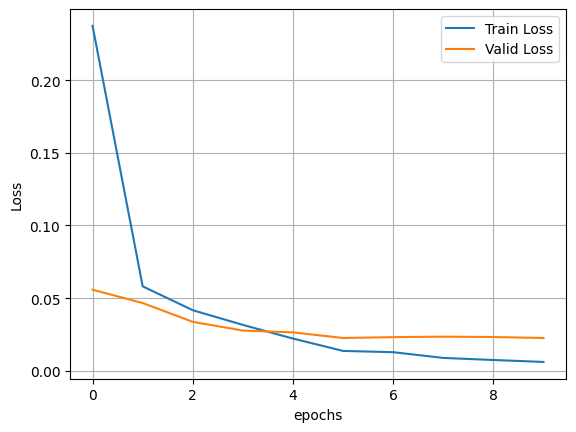

In [23]:
plt.plot( range(len(history["Train Loss"])), history["Train Loss"], label="Train Loss")
plt.plot( range(len(history["Valid Loss"])), history["Valid Loss"], label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

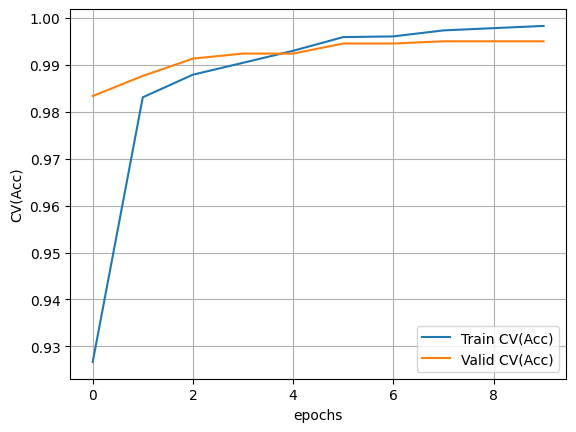

In [24]:
plt.plot( range(len(history["Train CV(Acc)"])), history["Train CV(Acc)"], label="Train CV(Acc)")
plt.plot( range(len(history["Valid CV(Acc)"])), history["Valid CV(Acc)"], label="Valid CV(Acc)")
plt.xlabel("epochs")
plt.ylabel("CV(Acc)")
plt.grid()
plt.legend()
plt.show()

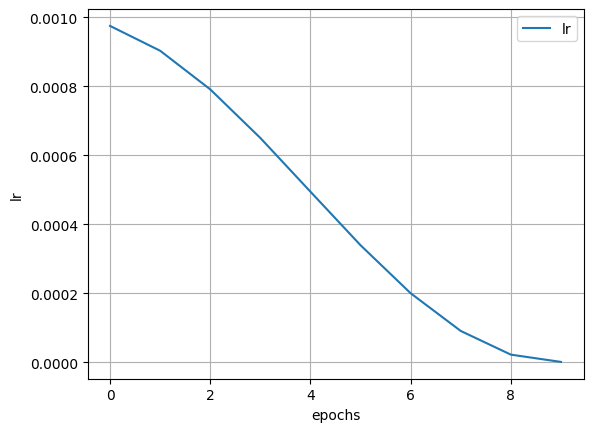

In [25]:
plt.plot( range(len(history["lr"])), history["lr"], label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()